In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
import logging
import math
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib import colors
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy
from scipy.spatial.distance import pdist, squareform
# from sklearn.decomposition import PCA
from sklearn.metrics import r2_score
import sys

sys.path.append('../../')
from data_utils import *

sys.path.append('../../../DeLASE')
from delase import *
from stability_estimation import *
from parameter_choosing import *
from performance_metrics import *

plt.style.use('../../sci_style.py')

# Load Data

In [3]:
# session = 'MrJones-Anesthesia-20160109-01'
session = 'Mary-Anesthesia-20160912-02'
results_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/session_results'

In [4]:
all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
# variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
# session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
# electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

In [5]:
eyes_open = session_info['eyesOpen'][-1] if isinstance(session_info['eyesOpen'], np.ndarray) else session_info['eyesOpen']
eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose']

In [6]:
section_times = dict( 
        wake=(0, session_info['drugStart'][0]),
        induction=(session_info['drugStart'][0], eyes_close),
        anesthesia=(eyes_close, session_info['drugEnd'][1]),
        recovery=(session_info['drugEnd'][1], T*dt)
)
sections = list(section_times.keys())

In [7]:
tone_on = trial_info['cpt_toneOn'][~np.isnan(trial_info['cpt_toneOn'])]
tone_off = trial_info['cpt_toneOff'][~np.isnan(trial_info['cpt_toneOff'])]

# PCA Trajectories

In [364]:
class PCA:
    def __init__(self, n_components=None):
        self.n_components = n_components
    
    def fit(self, data):
        data_centered = data - data.mean(axis=0)
        U, S, Vh = torch.linalg.svd(torch.from_numpy(data_centered).type('torch.DoubleTensor').cuda(), full_matrices=False)
        self.U = U.cpu().numpy()
        self.S = S.cpu().numpy()
        self.V = Vh.cpu().numpy().T
    
    def transform(self, data):
        mean_vals = data.mean(axis=0)
        return (data - mean_vals) @ self.V[:, :self.n_components]

In [365]:
leadup = 500
post = 1500
p = 10
# leadup = 500
# post = 1500

In [366]:
areas = ['vlPFC', 'FEF', '7b', 'CPB']

In [367]:
num_wake_samples = np.sum(tone_on <= session_info['drugStart'][0])
num_anesthesia_samples = np.sum(np.logical_and(tone_on > eyes_close, tone_on < session_info['drugEnd'][1]))
random_times = np.sort(np.random.uniform(0, session_info['drugStart'][0], size=(num_wake_samples,)))
random_times = np.hstack([random_times, np.sort(np.random.uniform(eyes_close, session_info['drugStart'][1], size=(num_anesthesia_samples,)))])

In [368]:
lfp_traj_wake = {}
lfp_traj_anesthesia = {}

for i, area in tqdm(enumerate(areas), total=len(areas)):
    
    lfp_traj_wake[area] = {}
    lfp_traj_anesthesia[area] = {}

    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
    for time_locs, time_loc_array in [('tone', tone_on), ('random', random_times)]:
    
        lfp_traj_wake[area][time_locs] = {}
        lfp_traj_anesthesia[area][time_locs] = {}
    
        lfp_tone_wake = []
        lfp_tone_anesthesia = []
        num_wake = 0
        num_anesthesia = 0
        for t in time_loc_array:
            if t < session_info['drugStart'][0]:
                t = int(t/dt)
                lfp_tone_wake.append(embed_signal(lfp[t - leadup -p + 1:t + post, unit_indices], p, use_torch=False))
                num_wake += 1
            elif t > eyes_close and t < session_info['drugEnd'][1]:
                t = int(t/dt)
                lfp_tone_anesthesia.append(embed_signal(lfp[t - leadup - p + 1:t + post, unit_indices], p, use_torch=False))
                num_anesthesia += 1
        lfp_tone_wake = np.array(lfp_tone_wake)
        lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)

        lfp_tone_wake_mean = lfp_tone_wake.mean(axis=0)
        lfp_tone_wake_se = lfp_tone_wake.mean(axis=0)/np.sqrt(lfp_tone_wake.shape[0])
        lfp_tone_anesthesia_mean = lfp_tone_anesthesia.mean(axis=0)
        lfp_tone_anesthesia_se = lfp_tone_anesthesia.mean(axis=0)/np.sqrt(lfp_tone_anesthesia.shape[0])


        embed_method = 'PCA'
        if embed_method == 'PCA':
            manifold_embed = PCA(n_components=3)
        elif embed_method == 'Isomap':
            manifold_embed = Isomap(n_components=3, n_neighbors=5)
        elif embed_method == 'TPHATE':
            manifold_embed = tphate.TPHATE(n_components=3, t=5, decay=5)

        stack = np.vstack([lfp_tone_wake_mean, lfp_tone_anesthesia_mean])
        manifold_embed.fit(stack)

        lfp_traj_wake[area][time_locs]['pca_mean_traj_shared'] = manifold_embed.transform(lfp_tone_wake_mean)
        lfp_traj_anesthesia[area][time_locs]['pca_mean_traj_shared'] = manifold_embed.transform(lfp_tone_anesthesia_mean)
        lfp_traj_wake[area][time_locs]['pca_se_traj_shared'] = manifold_embed.transform(lfp_tone_wake_se)
        lfp_traj_anesthesia[area][time_locs]['pca_se_traj_shared'] = manifold_embed.transform(lfp_tone_anesthesia_se)

        manifold_embed.fit(lfp_tone_wake_mean)
        lfp_traj_wake[area][time_locs]['pca_mean_traj_split'] = manifold_embed.transform(lfp_tone_wake_mean)
        manifold_embed.fit(lfp_tone_anesthesia_mean)
        lfp_traj_anesthesia[area][time_locs]['pca_mean_traj_split'] = manifold_embed.transform(lfp_tone_anesthesia_mean)

  0%|          | 0/4 [00:00<?, ?it/s]

In [369]:
shared = True
# time_locs = 'tone'
time_locs = 'random'

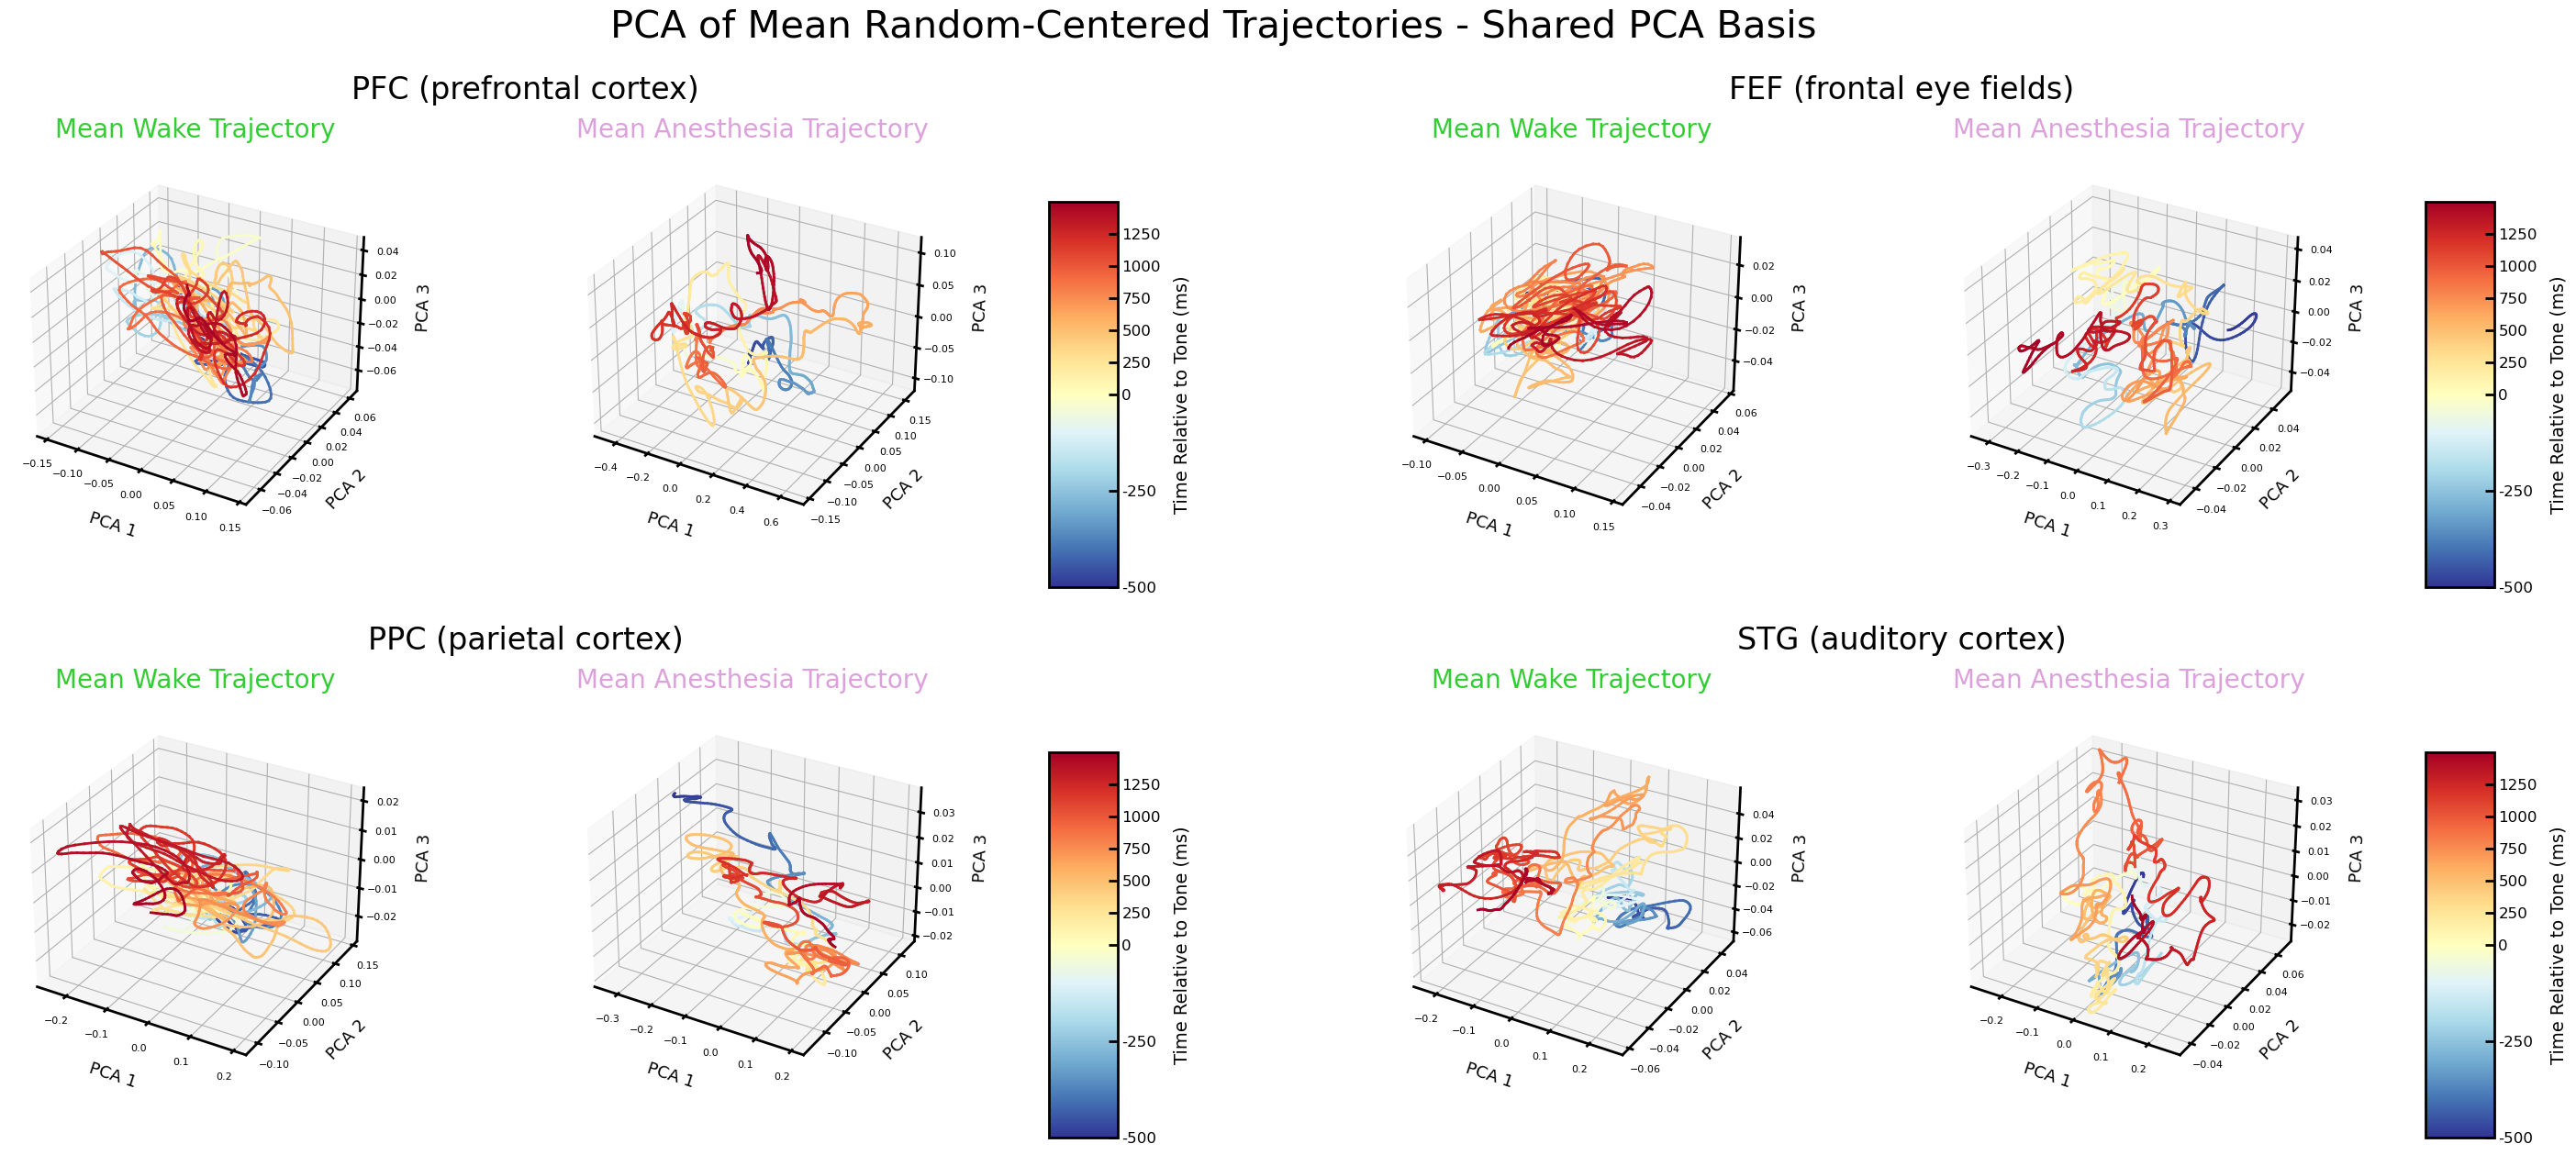

In [370]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}

area_labels = {
    'CPB': 'STG (auditory cortex)',
    '7b': 'PPC (parietal cortex)',
    'FEF': 'FEF (frontal eye fields)',
    'vlPFC': 'PFC (prefrontal cortex)'
}

fig = plt.figure(figsize=(30, 12))
fig.suptitle(f"PCA of Mean {time_locs.capitalize()}-Centered Trajectories - {'Shared' if shared else 'Split'} PCA Basis", fontsize=30, y=1.05)
# fig.subplots_adjust(top=0.85)
subfigs = fig.subfigures(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
for i, area in enumerate(areas):
    
    fig = subfigs[int(i/2)][i%2]
    fig.set_facecolor('none')
    
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=leadup, vmax=leadup + post)
    cmap = plt.cm.get_cmap('RdYlBu_r')
    
    axs = fig.subplots(1, 2, subplot_kw=dict(projection="3d"))
    fig.suptitle(f"{area_labels[area]}")
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    
    axis_label_fontsize = 13

    ax = axs[0]
#     ax.remove()
#     ax = fig.add_subplot(1, 2, 1,projection='3d')
    X = lfp_traj_wake[area][time_locs]['pca_mean_traj' + ('_shared' if shared else '_split')]
    for i in range(X.shape[0] - 1):
        ax.plot([X[i, 0], X[i+1, 0]], [X[i, 1], X[i+1, 1]], [X[i, 2], X[i+1, 2]], c=cmap(norm(i)))
    ax.set_xlabel('PCA 1', fontsize=axis_label_fontsize)
    ax.set_ylabel('PCA 2', fontsize=axis_label_fontsize)
    ax.set_zlabel('PCA 3', fontsize=axis_label_fontsize)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.set_title("Mean Wake Trajectory", fontsize=20, c='limegreen')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    ## ANESTHESIA !!!!!
    # X = manifold_embed.fit_transform(lfp_tone_anesthesia.mean(axis=0))
#     if embed_method == 'TPHATE':
#         manifold_embed = tphate.TPHATE(n_components=3, t=5, decay=5)
    # X = manifold_embed.fit_transform(lfp_tone_anesthesia[0])

    ax = axs[1]
#     ax.remove()
#     ax = fig.add_subplot(1, 2, 2,projection='3d')
    X = lfp_traj_anesthesia[area][time_locs]['pca_mean_traj' + ('_shared' if shared else '_split')]
    for i in range(X.shape[0] - 1):
        ax.plot([X[i, 0], X[i+1, 0]], [X[i, 1], X[i+1, 1]], [X[i, 2], X[i+1, 2]], c=cmap(norm(i)))
    ax.set_xlabel('PCA 1', fontsize=axis_label_fontsize)
    ax.set_ylabel('PCA 2', fontsize=axis_label_fontsize)
    ax.set_zlabel('PCA 3', fontsize=axis_label_fontsize) 
    ax.set_title("Mean Anesthesia Trajectory", fontsize=20, c='plum')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # plt.suptitle(f'{embed_method} of Tone Event-Related Potentials in {area_labels[area]}', fontsize=18)
#     plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.88, 0.05, 0.05, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
    cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)
    cbar.set_label(label='Time Relative to Tone (ms)', fontsize=14)
    

# Dynamic Mode Trajectories

In [289]:
p = 10
leadup = 500 + p - 1
post = 1500
# leadup = 500
# post = 1500

In [290]:
areas = ['vlPFC', 'FEF', '7b', 'CPB']

In [349]:
def compute_dynamic_modes(eigvals, eigvecs, verbose=False):
    dynamic_modes = np.zeros(eigvecs.shape)
    vec_num = 0
    iterator = tqdm(total=len(eigvals), disable=not verbose)
    while vec_num < len(eigvals):
        if np.imag(eigvals[vec_num]) == 0:
            dynamic_modes[:, vec_num] = np.real(eigvecs[vec_num])
            vec_num += 1
            iterator.update(1)
        else:
            v1 = np.real((eigvecs[vec_num] + eigvecs[vec_num + 1])/2)
            v2 = np.real((eigvecs[vec_num] - eigvecs[vec_num + 1])/2)
    #         if np.sum(np.imag(eigvecs[vec_num] + eigvecs[vec_num + 1])) > 1e-12:
    #             print(np.sum(np.imag(eigvecs[vec_num] + eigvecs[vec_num + 1])))
            dynamic_modes[:, vec_num] = np.real(v1)
            dynamic_modes[:, vec_num + 1] = np.real(v2)
            vec_num += 2
            iterator.update(2)
    iterator.close()
    
    return dynamic_modes

def compute_dmd_proj(data, p=1, r=None, num_trajs=None, orthogonalize=False, use_torch=False, device='cpu', verbose=False):
    if num_trajs is None:
        num_trajs = data.shape[0]

    delase = DeLASE(data[np.random.choice(data.shape[0], size=(num_trajs,), replace=False)], p=p, use_torch=use_torch, device=device)
    delase.compute_havok_dmd(r=r)

    eigvals, eigvecs = torch.linalg.eig(delase.A)

    eig_order = torch.flip(torch.real(eigvals).argsort(), (0,))
    eigvals = eigvals[eig_order].cpu().numpy()
    eigvecs = eigvecs[:, eig_order].cpu().numpy()

    delase.to('cpu')

    dynamic_modes = compute_dynamic_modes(eigvals, eigvecs, verbose=verbose)
    if orthogonalize:
        dynamic_modes, r = np.linalg.qr(dynamic_modes)

    H = np.zeros((data.shape[0], data.shape[1] - p + 1, data.shape[2]*p))
    for i in tqdm(range(data.shape[0])): 
        H[i] = embed_signal(data[i], p, use_torch=False)

    return H @ dynamic_modes, eigvals, dynamic_modes

In [342]:
lfp_traj_wake = {}
lfp_traj_anesthesia = {}

for i, area in tqdm(enumerate(areas), total=len(areas)):
    
    lfp_traj_wake[area] = {}
    lfp_traj_anesthesia[area] = {}

    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]
    
    for time_locs, time_loc_array in [('tone', tone_on), ('random', random_times)]:
    
        lfp_traj_wake[area][time_locs] = {}
        lfp_traj_anesthesia[area][time_locs] = {}
    
        lfp_tone_wake = []
        lfp_tone_anesthesia = []
        num_wake = 0
        num_anesthesia = 0
        for t in time_loc_array:
            if t < session_info['drugStart'][0]:
                t = int(t/dt)
                lfp_tone_wake.append(lfp[t - leadup:t + post, unit_indices])
                num_wake += 1
            elif t > eyes_close and t < session_info['drugEnd'][1]:
                t = int(t/dt)
                lfp_tone_anesthesia.append(lfp[t - leadup:t + post, unit_indices])
                num_anesthesia += 1
        lfp_tone_wake = np.array(lfp_tone_wake)
        lfp_tone_anesthesia = np.array(lfp_tone_anesthesia)

        lfp_tone_wake_mean = lfp_tone_wake.mean(axis=0)
        lfp_tone_wake_se = lfp_tone_wake.mean(axis=0)/np.sqrt(lfp_tone_wake.shape[0])
        lfp_tone_anesthesia_mean = lfp_tone_anesthesia.mean(axis=0)
        lfp_tone_anesthesia_se = lfp_tone_anesthesia.mean(axis=0)/np.sqrt(lfp_tone_anesthesia.shape[0])
        
        if time_locs == 'random':
            raise ValueError

  0%|          | 0/4 [00:00<?, ?it/s]

ValueError: 

In [350]:
r = 200

In [353]:
orthogonalize=True

In [351]:
lfp_tone_wake_dmd, eigvals_wake, dynamic_modes_wake = compute_dmd_proj(lfp_tone_wake, p, r=r, num_trajs = 50, orthogonalize=orthogonalize, use_torch=True, device='cpu', verbose=True)

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/132 [00:00<?, ?it/s]

In [354]:
lfp_tone_anesthesia_dmd, eigvals_anesthesia, dynamic_modes_anesthesia = compute_dmd_proj(lfp_tone_anesthesia, p, r=r, num_trajs = 50, orthogonalize=orthogonalize, use_torch=True, device='cpu', verbose=True)

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/408 [00:00<?, ?it/s]

In [361]:
dmd_inds = [1, 2, 3]

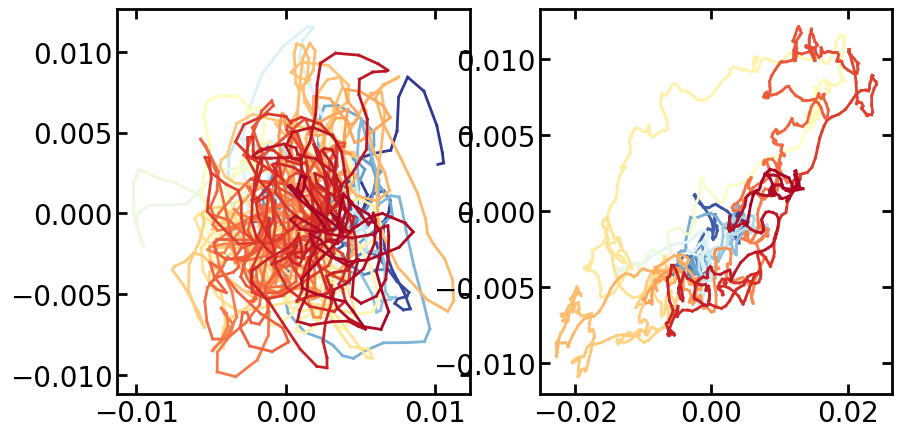

In [362]:
norm = colors.TwoSlopeNorm(vmin=0, vcenter=leadup, vmax=leadup + post)
cmap = plt.cm.get_cmap('RdYlBu_r')
fig, axs = plt.subplots(1, 2, subplot_kw=dict(projection="3d"))
# fig, axs = plt.subplots(1, 2)
ax = axs[0]
X = lfp_tone_wake_dmd.mean(axis=0)
for i in range(X.shape[0] - 1):
    ax.plot([X[i, dmd_inds[0]], X[i+1, dmd_inds[0]]], [X[i, dmd_inds[1]], X[i+1, dmd_inds[1]]], [X[i, dmd_inds[2]], X[i+1, dmd_inds[2]]], c=cmap(norm(i)))
#     ax.plot([X[i, dmd_inds[0]], X[i+1, dmd_inds[0]]], [X[i, dmd_inds[1]], X[i+1, dmd_inds[1]]], c=cmap(norm(i)))

ax = axs[1]
X = lfp_tone_anesthesia_dmd.mean(axis=0)
for i in range(X.shape[0] - 1):
#     ax.plot([X[i, dmd_inds[0]], X[i+1, dmd_inds[0]]], [X[i, dmd_inds[1]], X[i+1, dmd_inds[1]]], [X[i, dmd_inds[2]], X[i+1, dmd_inds[2]]], c=cmap(norm(i)))
    ax.plot([X[i, dmd_inds[0]], X[i+1, dmd_inds[0]]], [X[i, dmd_inds[1]], X[i+1, dmd_inds[1]]], c=cmap(norm(i)))

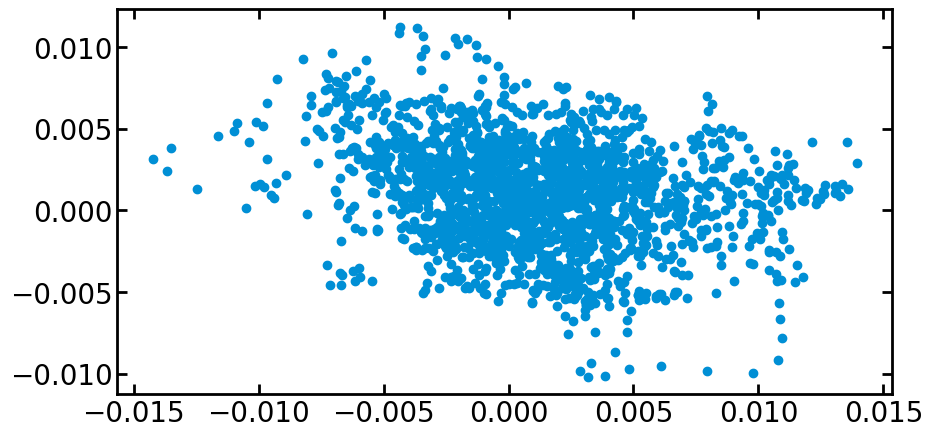

In [357]:
plt.scatter(lfp_tone_wake_dmd[:, :, 0].mean(axis=0), lfp_tone_wake_dmd[:, :, 1].mean(axis=0))

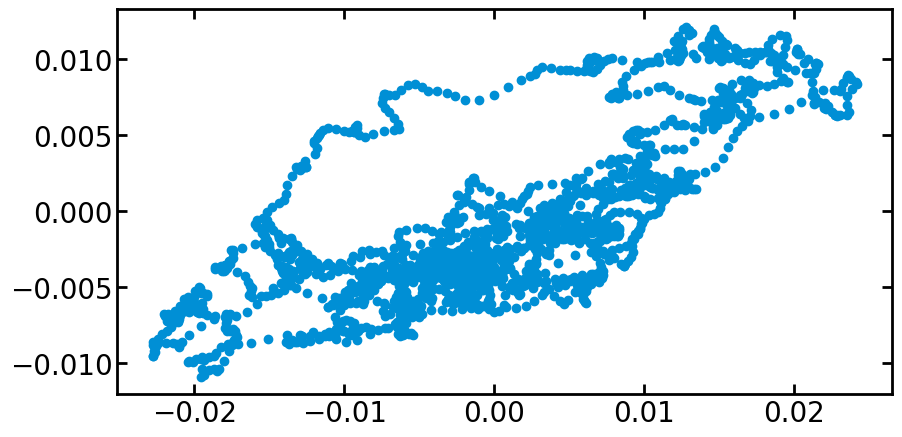

In [360]:
plt.scatter(lfp_tone_anesthesia_dmd[:, :, 1].mean(axis=0), lfp_tone_anesthesia_dmd[:, :, 2].mean(axis=0))

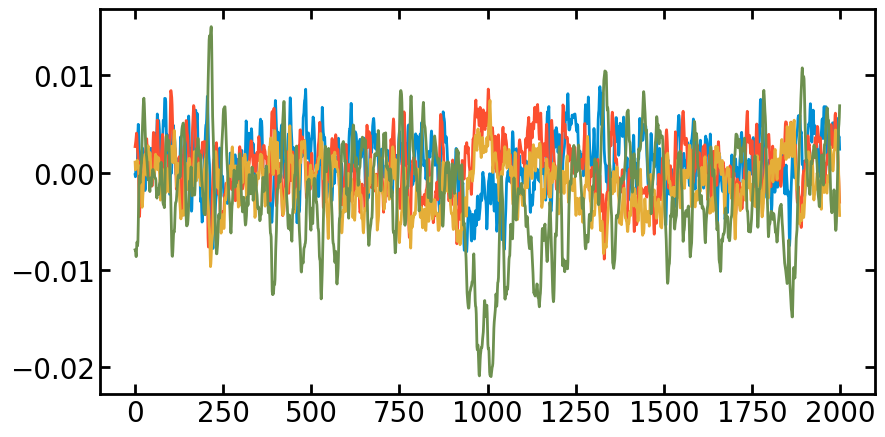

In [329]:
plt.plot(lfp_tone_wake_dmd.mean(axis=0)[:, 0])
plt.plot(lfp_tone_wake_dmd.mean(axis=0)[:, 1])
plt.plot(lfp_tone_wake_dmd.mean(axis=0)[:, 2])
plt.plot(lfp_tone_wake_dmd.mean(axis=0)[:, 3])

In [337]:
scipy.stats.pearsonr(lfp_tone_anesthesia_dmd.mean(axis=0)[:, 0], lfp_tone_anesthesia_dmd.mean(axis=0)[:, 2])

(0.11074915148856396, 6.868826741255608e-07)

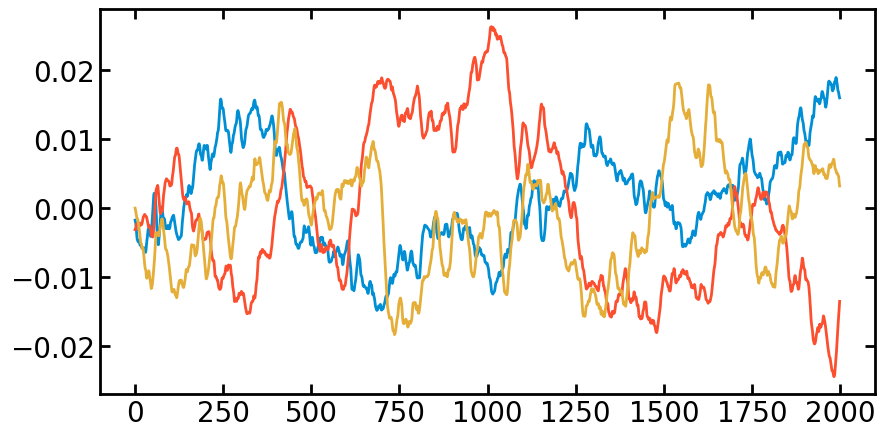

In [334]:
plt.plot(lfp_tone_anesthesia_dmd.mean(axis=0)[:, 0])
plt.plot(lfp_tone_anesthesia_dmd.mean(axis=0)[:, 1])
plt.plot(lfp_tone_anesthesia_dmd.mean(axis=0)[:, 2])
# plt.plot(lfp_tone_anesthesia_dmd.mean(axis=0)[:, 3])

In [215]:
lfp_tone_anesthesia_dmd.mean(axis=0).shape

(2001, 640)

In [ ]:
area_colors = {
    'CPB': 'lightsteelblue', 
    '7b': 'slategray',
    'FEF': 'skyblue',
    'vlPFC': 'C0',
    'all': 'purple'
}

area_labels = {
    'CPB': 'STG (auditory cortex)',
    '7b': 'PPC (parietal cortex)',
    'FEF': 'FEF (frontal eye fields)',
    'vlPFC': 'PFC (prefrontal cortex)'
}

fig = plt.figure(figsize=(30, 12))
fig.suptitle(f"PCA of Mean Tone-Evoked Trajectories - {'Shared' if shared else 'Split'} PCA Basis", fontsize=30, y=1.05)
# fig.subplots_adjust(top=0.85)
subfigs = fig.subfigures(2, 2, height_ratios=[1, 1], width_ratios=[1, 1])
for i, area in enumerate(areas):
    
    fig = subfigs[int(i/2)][i%2]
    fig.set_facecolor('none')
    
    norm = colors.TwoSlopeNorm(vmin=0, vcenter=leadup, vmax=leadup + post)
    cmap = plt.cm.get_cmap('RdYlBu_r')
    
    axs = fig.subplots(1, 2, subplot_kw=dict(projection="3d"))
    fig.suptitle(f"{area_labels[area]}")
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    
    axis_label_fontsize = 13

    ax = axs[0]
#     ax.remove()
#     ax = fig.add_subplot(1, 2, 1,projection='3d')
    X = lfp_traj_wake[area]['tone']['pca_mean_traj' + ('_shared' if shared else '_split')]
    for i in range(X.shape[0] - 1):
        ax.plot([X[i, 0], X[i+1, 0]], [X[i, 1], X[i+1, 1]], [X[i, 2], X[i+1, 2]], c=cmap(norm(i)))
    ax.set_xlabel('PCA 1', fontsize=axis_label_fontsize)
    ax.set_ylabel('PCA 2', fontsize=axis_label_fontsize)
    ax.set_zlabel('PCA 3', fontsize=axis_label_fontsize)
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.set_title("Mean Wake Trajectory", fontsize=20, c='limegreen')
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    ## ANESTHESIA !!!!!
    # X = manifold_embed.fit_transform(lfp_tone_anesthesia.mean(axis=0))
#     if embed_method == 'TPHATE':
#         manifold_embed = tphate.TPHATE(n_components=3, t=5, decay=5)
    # X = manifold_embed.fit_transform(lfp_tone_anesthesia[0])

    ax = axs[1]
#     ax.remove()
#     ax = fig.add_subplot(1, 2, 2,projection='3d')
    X = lfp_traj_anesthesia[area]['tone']['pca_mean_traj' + ('_shared' if shared else '_split')]
    for i in range(X.shape[0] - 1):
        ax.plot([X[i, 0], X[i+1, 0]], [X[i, 1], X[i+1, 1]], [X[i, 2], X[i+1, 2]], c=cmap(norm(i)))
    ax.set_xlabel('PCA 1', fontsize=axis_label_fontsize)
    ax.set_ylabel('PCA 2', fontsize=axis_label_fontsize)
    ax.set_zlabel('PCA 3', fontsize=axis_label_fontsize) 
    ax.set_title("Mean Anesthesia Trajectory", fontsize=20, c='plum')
    # ax.set_xticks([])
    # ax.set_yticks([])
    # ax.set_zticks([])
    ax.tick_params(axis='both', which='major', labelsize=8)
    ax.tick_params(axis='both', which='minor', labelsize=8)

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    # plt.suptitle(f'{embed_method} of Tone Event-Related Potentials in {area_labels[area]}', fontsize=18)
#     plt.tight_layout()
    fig.subplots_adjust(right=0.8)
    cbar_ax = fig.add_axes([0.88, 0.05, 0.05, 0.7])
    cbar = fig.colorbar(sm, cax=cbar_ax, ticks=np.arange(0, leadup + post, 250), label='Time Relative to Tone (ms)')
    cbar.ax.set_yticklabels(np.arange(-leadup, post, 250), fontsize=12)
    cbar.set_label(label='Time Relative to Tone (ms)', fontsize=14)
    